셀 1 — 준비/헬퍼

In [1]:
import math, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from arc import Caesium, Rubidium  # 원자 선택

# 사용자 설정
ATOM = "Cs"                         # "Cs" 또는 "Rb"
START_STATE = (14, 1, 1.5)          # (n, l, j) 예: 14P3/2 → (14,1,1.5)
SHOTS = 10000                       # Monte Carlo 샷(커질수록 매끄러움↑)
MAX_STEPS = 10                      # 캐스케이드 최대 단계
VISIBLE_WINDOW = (500e-9, 600e-9)   # 500–600 nm
SEED = 7
random.seed(SEED)

def make_atom(name="Cs"):
    return Caesium() if name.lower() in ("cs","caesium","cesium") else Rubidium()

def l_to_letter(l):
    return "SPDFGH"[l] if l < 6 else f"L{l}"

def state_str(s):
    n,l,j = s
    return f"{n}{l_to_letter(l)}_{int(2*j)}/2"

def in_window(lam_m, win):
    return lam_m>0 and (win[0] <= lam_m <= win[1])


셀 2 — 가능한 하향 전이/전이율, 1회 캐스케이드, 스펙트럼 생성

In [2]:
def allowed_lowers(atom, s, n_floor=5):
    """상태 s=(n,l,j)에서 E1 허용 하향 후보 생성 + A (Einstein rate) 계산."""
    n,l,j = s
    outs = []
    for lp in (l-1, l+1):
        if lp < 0: 
            continue
        for jp in (lp-0.5, lp+0.5):
            if jp <= 0:
                continue
            # n' 범위: [n_floor .. n-1]
            for np_ in range(max(n_floor,5), n):
                try:
                    A = atom.getTransitionRate(n,l,j, np_,lp,jp)  # [s^-1]
                except Exception:
                    A = 0.0
                if A > 0:
                    outs.append(((np_,lp,jp), A))
    return outs  # [(state', A), ...]

def cascade_once(atom, start, max_steps=10):
    """1회 붕괴 시뮬레이션: 방출된 파장 리스트(미터 단위) 반환."""
    s = start
    emitted = []
    for _ in range(max_steps):
        candidates = allowed_lowers(atom, s)
        if not candidates:
            break
        # A로 가중한 무작위 선택
        Avals = np.array([A for _,A in candidates], dtype=float)
        pick = random.random() * Avals.sum()
        acc = 0.0
        next_state = None
        for (t,A) in candidates:
            acc += A
            if pick <= acc:
                next_state = t
                break
        # 방출 파장 기록
        try:
            lam = abs(atom.getTransitionWavelength(*s, *next_state))  # [m]
        except Exception:
            lam = 0.0
        if lam > 0:
            emitted.append(lam)
        # 낮은 준위(대략 n<=7, l<=1)에서 종료
        if next_state[0] <= 7 and next_state[1] <= 1:
            break
        s = next_state
    return emitted

def spectrum_mc(atom, start, shots=10000, max_steps=10):
    """여러 샷에서 파장 누적 → numpy array (m) 반환."""
    bag = []
    for _ in range(shots):
        bag.extend(cascade_once(atom, start, max_steps=max_steps))
    return np.array(bag, dtype=float)


셀 3 — 실행 & 그래프 (히스토그램)

Start: 14P_3/2 | 샷=10000, 단계≤10
전체 방출수(가시권 350–750 nm): 1278
500–600 nm 평균 광자수/여기: 0.0335


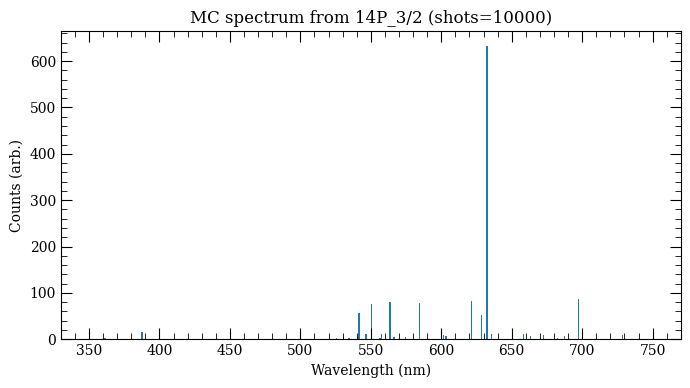

In [ ]:
atom = make_atom(ATOM)
wls_m = spectrum_mc(atom, START_STATE, shots=SHOTS, max_steps=MAX_STEPS)

# nm로 변환 후, 가시권만 보기(예: 350–750 nm)
wls_nm = wls_m * 1e9
mask = (wls_nm > 350) & (wls_nm < 750)
wls_nm_vis = wls_nm[mask]

# 500–600 nm 수율(여기당 평균 광자수)
vis_mask = (wls_nm > 500) & (wls_nm < 600)
visible_yield = vis_mask.sum() / SHOTS

print(f"Start: {state_str(START_STATE)} | 샷={SHOTS}, 단계≤{MAX_STEPS}")
print(f"전체 방출수(가시권 350–750 nm): {wls_nm_vis.size}")
print(f"500–600 nm 평균 광자수/여기: {visible_yield:.4f}")

# 히스토그램 (빈 폭은 1nm 권장)
bins = np.arange(350, 751, 1.0)
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(wls_nm_vis, bins=bins)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Counts (arb.)")
ax.set_title(f"MC spectrum from {state_str(START_STATE)} (shots={SHOTS})")
plt.show()
 

셀 4 — 라인 리스트(대략적인 피크 표)

In [ ]:
# 1 nm bin으로 라인-카운트 집계 → 상위 라인 몇 개
counts, edges = np.histogram(wls_nm_vis, bins=np.arange(350, 751, 1.0))
centers = 0.5*(edges[:-1]+edges[1:])
df_lines = (pd.DataFrame({"λ_nm": centers, "counts": counts})
              .query("counts>0")
              .sort_values("counts", ascending=False)
              .head(20)
              .reset_index(drop=True))
df_lines


어떻게 해석하나요?
히스토그램 봉우리가 바로 **가능한 붕괴선(여러 단계 포함)**의 상대 강도에 해당합니다(샷 수를 늘릴수록 이론적 분포에 수렴).
콘솔에 찍히는 500–600 nm 평균 광자수/여기가 카메라 민감 대역에서의 기대 광자수(= Downes 논문의 pon 계열에 대응)입니다.
시작 상태를 두 후보(예: nP↔(n−1)D) 각각에 대해 돌려서 스펙트럼과 수율을 비교하면, “THz로 어느 쪽 인구를 만들었을 때 변환 효율이 더 좋은가?”를 정량 비교할 수 있습니다.
팁: 실제 THz는 두 상태를 혼합(라비 스플리팅)하므로, 두 스펙트럼의 가중합(가중치는 혼합 계수/점유율)으로 THz-on 스펙트럼을 근사할 수 있어요.